In [3]:
import os
import pandas as pd
import re
import random
import json
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm, trange as notebook_tqdm, trange
from transformers import AutoTokenizer, AutoModel
import torch

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
from datasets import load_dataset

dataset = load_dataset("MBZUAI/LaMini-instruction")

Found cached dataset parquet (/home/kromanova/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


In [ ]:
dataset

In [6]:
import pandas as pd
df = pd.DataFrame(dataset["train"][:100000])

In [7]:
df.drop("instruction_source", axis=1, inplace=True)

In [10]:
df = df.reset_index() 

In [11]:
df.drop('index', axis=1, inplace=True)

# Расширение токенайзера

In [10]:
from collections import Counter, defaultdict
import numpy as np

In [4]:
from transformers import AutoModelForPreTraining, AutoTokenizer, BertTokenizer

2023-07-02 22:06:24.456220: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-02 22:06:24.491014: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-02 22:06:24.492164: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
base_model = 'cointegrated/LaBSE-en-ru'

In [5]:
tokenizer = BertTokenizer.from_pretrained(base_model)
print(tokenizer.vocab_size)

55083


In [6]:
model = AutoModelForPreTraining.from_pretrained(base_model)

[2023-07-02 22:06:32,161] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [15]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [16]:
model

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(55083, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

# Train

In [17]:
for p in model.parameters():
    p.requires_grad = False
for p in model.bert.embeddings.word_embeddings.parameters():
    p.requires_grad = True

In [18]:
batch_size = 16
margin = 0.3

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [21]:
def get_acc(embeddings):
    batch_size = embeddings.shape[0] // 2
    with torch.no_grad():
        scores = torch.matmul(
            embeddings[:batch_size].detach(),
            embeddings[batch_size:].T
        ).cpu().numpy()
    a1 = (scores.argmax(1) == np.arange(batch_size)).mean()
    a2 = (scores.argmax(0) == np.arange(batch_size)).mean()
    return (a1 + a2) / 2

In [22]:
losses = []

In [23]:
accuracies = []

In [24]:
all_pairs = list(df.itertuples(index=False, name=None))

In [25]:
import logging

# создаем логгер
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# создаем файловый обработчик логов
file_handler = logging.FileHandler('train.log')
file_handler.setLevel(logging.DEBUG)

# создаем форматтер для логов
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# добавляем обработчик в логгер
logger.addHandler(file_handler)

In [26]:
len(all_pairs)

100000

In [27]:
model.to('cuda')

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(55083, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
model.train()
tq = trange(300_000)
for i in tq:
    myv, ru = [list(p) for p in zip(*random.choices(all_pairs, k=batch_size))]
    try:
        batch = tokenizer(ru+myv, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
        out = model.bert(**batch, output_hidden_states=True)
        embeddings = torch.nn.functional.normalize(out.pooler_output)
        all_scores = torch.matmul(
            embeddings[:batch_size].detach(), # keep Russian embeddings frozen
            embeddings[batch_size:].T  # update Erzya embeddings
        ) - torch.eye(batch_size, device=model.device) * margin
        loss = loss_fn(all_scores, torch.arange(batch_size, device=model.device)) + loss_fn(all_scores.T, torch.arange(batch_size, device=model.device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())
        logger.debug(f"Step {i} - Batch loss: {loss.item():.4f}")
        accuracies.append(get_acc(embeddings))
    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in myv+ru))
        continue
    if i % 100 == 0:
        print(i, np.mean(losses[-100:]), np.mean(accuracies[-100:]))

  0%|                                                                                                                                                                                                                   | 2/300000 [00:00<31:25:09,  2.65it/s]

0 5.4809675216674805 0.90625


  0%|                                                                                                                                                                                                                  | 31/300000 [00:04<11:26:47,  7.28it/s]

In [29]:
optimizer.zero_grad(set_to_none=True)
batch, out, embeddings, all_scores, loss = None, None, None, None, None
cleanup()

In [30]:
len(losses)

300000

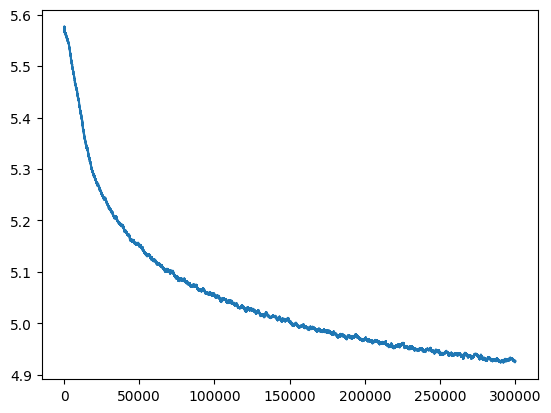

In [31]:
pd.Series(losses).ewm(1000).mean()[100:].plot();

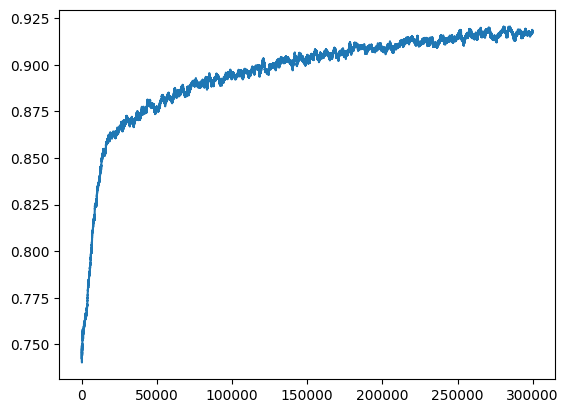

In [32]:
pd.Series(accuracies).ewm(1000).mean()[100:].plot();

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
model.push_to_hub('zjkarina/LaBSE-instructDialogs')
tokenizer.push_to_hub('zjkarina/LaBSE-instructDialogs')

pytorch_model.bin:   0%|          | 0.00/516M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/zjkarina/LaBSE-instructDialogs/commit/8a32f9e3fd79534e8e36d6a5b7a0b94faa130f77', commit_message='Upload tokenizer', commit_description='', oid='8a32f9e3fd79534e8e36d6a5b7a0b94faa130f77', pr_url=None, pr_revision=None, pr_num=None)

In [33]:
NEW_MODEL_NAME = 'labse_instruct' # the same model name; updated embeddings
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('labse_di/tokenizer_config.json',
 'labse_di/special_tokens_map.json',
 'labse_di/vocab.txt',
 'labse_di/added_tokens.json')